# Fix midpoints
> We have been taking midpoints of angles as .5(x+y). How do we actually find the hyperbolic midpoint?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from geomstats.geometry.hyperbolic import Hyperbolic
from geomstats.visualization import plot as gplot

from src.hyperdt.visualization import _get_geodesic, plot_boundary
from src.hyperdt.tree import HyperbolicDecisionTreeClassifier


INFO: Using numpy backend


In [3]:
# Preliminary stuff - takes a while, so let's run it only once

manifold = Hyperbolic(dim=2, default_coords_type="extrinsic")
start_theta = 1 / 4 * np.pi + 0.1
end_theta = 3 / 4 * np.pi - 0.1
thetas = np.linspace(start_theta, end_theta, 100)
geodesics = [
    _get_geodesic(
        dim=1,
        theta=theta,
        geometry="hyperboloid",
        t_dim=2,
    )
    for theta in thetas
]


AttributeError: 'Axes' object has no attribute 'colorbar'

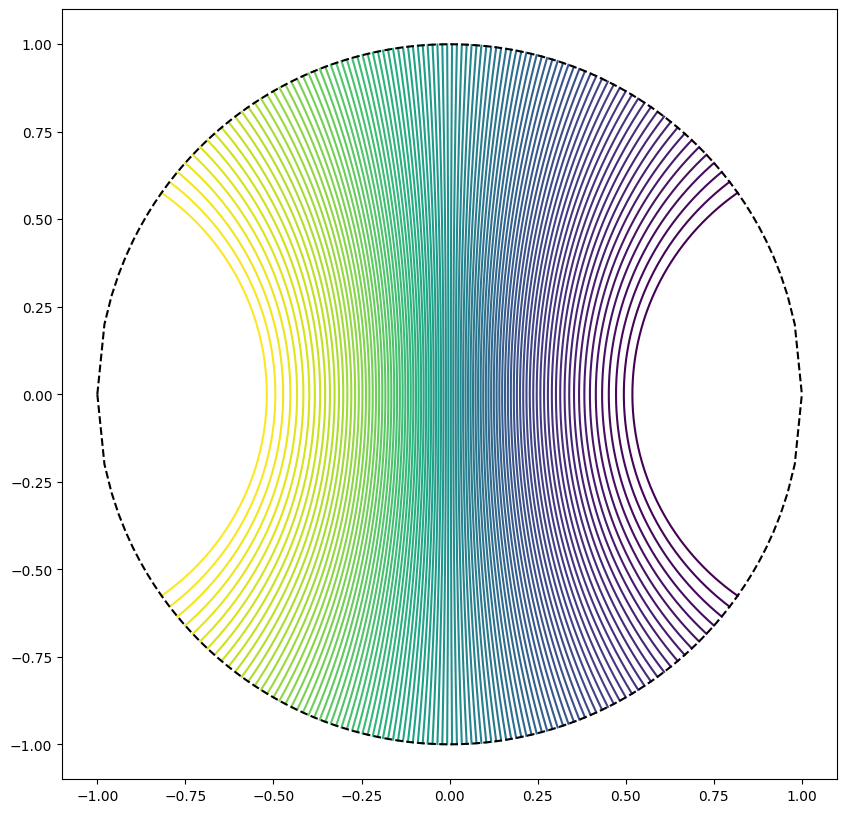

In [5]:
# Quick sanity check on plot_boundary code:
from matplotlib.colors import Normalize

fig, ax = plt.subplots(figsize=(10, 10))
# Make colors
cmap = plt.get_cmap("viridis", len(thetas))
colors = cmap(np.linspace(0, 1, len(thetas)))
for theta, color in zip(thetas, colors):
    ax = plot_boundary(1, theta, ax=ax, color=color)
_x = np.linspace(-1, 1, 100)
_y = np.sqrt(1 - _x ** 2)
ax.plot(_x, _y, "k--")
ax.plot(_x, -_y, "k--")
ax.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=0.25, vmax=0.75)),
    label="theta (fraction of $\pi$)",
)
plt.show()


Text(0.5, 1.0, 'Distance aberration by geodesic ')

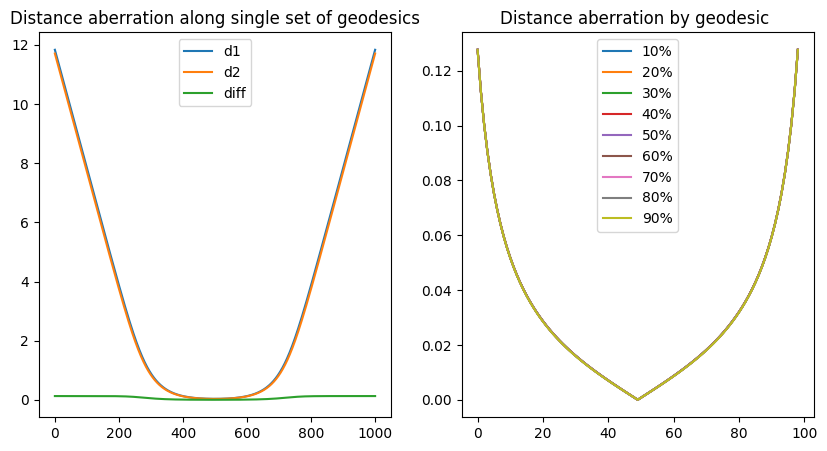

In [ ]:
# The main loop:

dists = {i: [] for i in range(10, 100, 10)}  # Every 10
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i in range(len(thetas) - 1):
    theta_1 = thetas[i]
    theta_2 = thetas[i + 1]
    geodesic_1 = geodesics[i]
    geodesic_2 = geodesics[i + 1]

    midpoint = (theta_1 + theta_2) / 2
    geodesic_m = _get_geodesic(
        dim=1, theta=midpoint, geometry="hyperboloid", t_dim=2
    )

    dists_1_m = [
        manifold.metric.dist(g1, gm) for g1, gm in zip(geodesic_1, geodesic_m)
    ]
    dists_2_m = [
        manifold.metric.dist(g2, gm) for g2, gm in zip(geodesic_2, geodesic_m)
    ]

    if i == 0:
        ax[0].plot(dists_1_m, label="d1")
        ax[0].plot(dists_2_m, label="d2")
        ax[0].plot(
            np.abs(np.array(dists_1_m) - np.array(dists_2_m)), label="diff"
        )
        ax[0].legend()
        ax[0].set_title("Distance aberration along single set of geodesics")
    for i in range(10, 100, 10):
        dists[i].append(np.abs(dists_1_m[i] - dists_2_m[i]))

for i in range(10, 100, 10):
    ax[1].plot(dists[i], label=f"{i}%")
ax[1].legend()
ax[1].set_title("Distance aberration by geodesic ")

# So basically we see that:
# 1. Distance aberration depends on where on the arc we are
# 2. Distance aberration does NOT depend on the specific values of the thetas


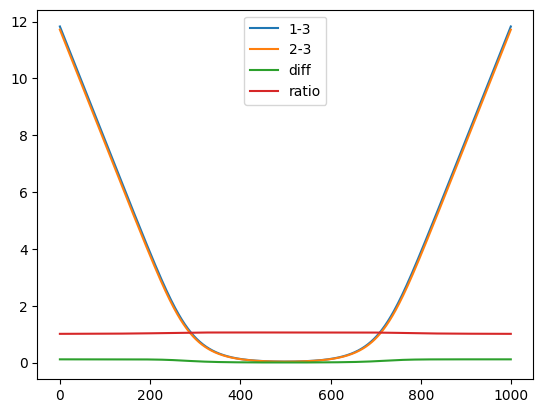

In [ ]:
# Model system: geodesics 1, 2:

th1 = thetas[0]
th2 = thetas[1]

# midpoint = (th1 + th2) / 2 # Euclidean mean
# midpoint = np.arctan2(np.sin(th1) + np.sin(th2), np.cos(th1) + np.cos(th2)) # Riemannian mean
# midpoint = np.arctanh(np.tanh(th1) + np.tanh(th2))  # Hyperbolic mean
midpoint = np.sqrt(th1 * th2)  # Lorentzian mean
mid_geodesic = _get_geodesic(
    dim=1, theta=midpoint, geometry="hyperboloid", t_dim=2
)

dists_1_m = np.array(
    [manifold.metric.dist(g1, gm) for g1, gm in zip(geodesics[0], mid_geodesic)]
)
dists_2_m = np.array(
    [manifold.metric.dist(gm, g3) for gm, g3 in zip(geodesics[1], mid_geodesic)]
)

plt.plot(dists_1_m, label="1-3")
plt.plot(dists_2_m, label="2-3")
plt.plot(dists_1_m - dists_2_m, label="diff")
plt.plot(dists_1_m / dists_2_m, label="ratio")
plt.title("Distance from midpoint")
plt.legend()
plt.show()


In [ ]:
# Can I find a theta that minimizes the distance aberration?


def minimize_distance_aberration(theta_1, theta_2, dim=2, timelike_dim=0):
    """Find the theta that minimizes the distance aberration between two points"""
    geodesic_1 = _get_geodesic(
        dim, theta_1, timelike_dim=timelike_dim, geometry="hyperboloid"
    )
    geodesic_2 = _get_geodesic(
        dim, theta_2, timelike_dim=timelike_dim, geometry="hyperboloid"
    )

    min_theta = np.min([theta_1, theta_2])
    max_theta = np.max([theta_1, theta_2])

    best_score = np.inf
    best_theta = None
    best_geodesic = None
    for theta in np.linspace(min_theta, max_theta, 100):
        geodesic_m = _get_geodesic(
            dim, theta, timelike_dim=timelike_dim, geometry="hyperboloid"
        )
        dist1 = np.array(
            [
                manifold.metric.dist(g1, gm)
                for g1, gm in zip(geodesic_1, geodesic_m)
            ]
        )
        dist2 = np.array(
            [
                manifold.metric.dist(g2, gm)
                for g2, gm in zip(geodesic_2, geodesic_m)
            ]
        )
        score = np.sum(np.abs(dist1 - dist2))
        if score < best_score:
            best_score = score
            best_theta = theta
            best_geodesic = geodesic_m

    print("Best score:", best_score)

    return best_theta, best_geodesic


best_theta, best_geodesic = minimize_distance_aberration(
    , theta_2, dim=2, timelike_dim=0
)


SyntaxError: invalid syntax (59029884.py, line 47)

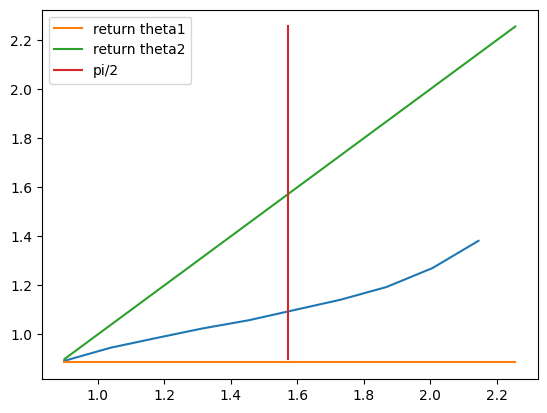

In [ ]:
# Plot best theta as a function of theta_2

# best_thetas = [
#     minimize_distance_aberration(thetas[0], t2, dim=2, timelike_dim=0)[0]
#     for t2 in thetas[1:100:10]
# ]
plt.plot(thetas[1:100:10], best_thetas)
plt.plot([thetas[1], thetas[99]], [thetas[0]] * 2, label="return theta1")
plt.plot(
    [thetas[1], thetas[99]], [thetas[1], thetas[99]], label="return theta2"
)
plt.plot([np.pi / 2] * 2, [thetas[1], thetas[99]], label="pi/2")
plt.legend()


# Where does theta hit on the hyperboloid?

I think we're getting muddled by talking about geodesics. Let's consider just a cross-section of the hyperbola in the plane
where all dimensions outside of $x_D, x_0$ are 0. The remaining variables have a simple relationship:
$$
x_D^2 - x_0^2 = -1
$$

Additionally, we would like to have that 
$$
x_0 = a\sin(\theta)\\
x_D = a\cos(\theta)
$$

Notice that, for a fixed theta, this is a single-variable problem: we only have to solve for $a$. Let's do this now:
$$
\begin{align*}
x_D^2 - x_0^2 &= -1\\
x_D^2 &= -1 + x_0^2\\
a^2\cos^2(\theta) &= -1 + a^2\sin^2(\theta)\\
a^2(\cos^2(\theta) - \sin^2(\theta))  &= -1\\
a^2 &= \frac{-1}{\cos^2(\theta) - \sin^2(\theta)}\\
a^2 &= \frac{-1}{\cos(2\theta)} \text{ (double angle formula)}\\
a^2 &= -\sec(2\theta)\\
a & = \sqrt{-\sec(2\theta)}
\end{align*}
$$

Finally, we can plug our $a$ back into the equations to determine that, for any $\theta$, our plane intersects this hyperboloid at
$$
x_0 = \sqrt{-\sec(2\theta)}\sin(\theta)\\
x_D = \sqrt{-\sec(2\theta)}\cos(\theta)
$$

Let's show this with a toy example (a 2-D plot):

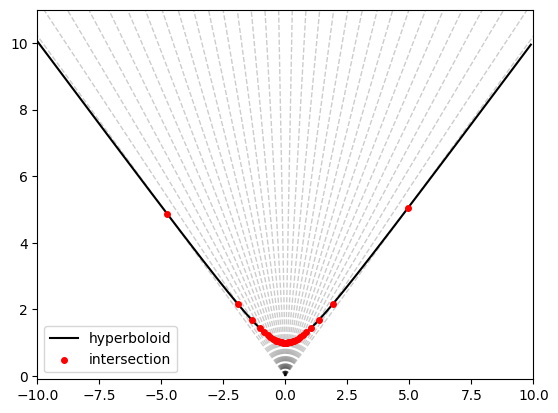

In [ ]:
# Show that x0 = sqrt(-sec(2theta)sin(theta)), xD = sqrt(-sec(2theta)cos(theta))
# is a solution to the hyperboloid equation:

_xD = np.arange(-10, 10, 0.1)
_x0 = np.sqrt(1 + _xD ** 2)
plt.plot(_xD, _x0, color="black", label="hyperboloid")  # Flip x,y

_a = np.arange(0, 20, 0.1)

thetas = np.arange(np.pi / 4 + 0.01, 3 * np.pi / 4 - 0.01, 0.05)
intersections = []
for theta in thetas:
    a = np.sqrt(-1 / np.cos(2 * theta))  # -sec(2 theta)^(1/2)
    intersections.append((a * np.sin(theta), a * np.cos(theta)))
    plt.plot(
        _a * np.cos(theta),
        _a * np.sin(theta),  # Flip x,y
        color="black",
        linestyle="--",
        lw=1,
        alpha=0.2,
    )
intersections = np.array(intersections)
plt.scatter(
    intersections[:, 1],
    intersections[:, 0],
    color="red",
    label="intersection",
    s=16,
    zorder=3,
)  # Flip x,y

plt.ylim(-0.1, 11)
plt.xlim(-10, 10)
plt.legend()
plt.show()


[]

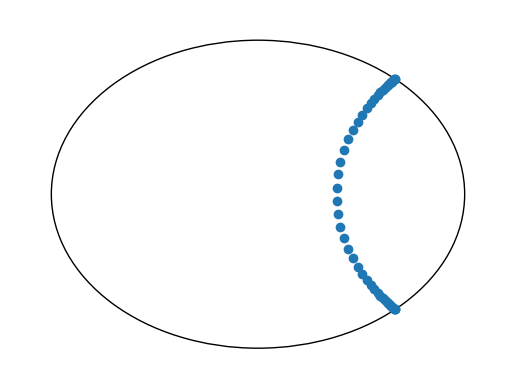

In [ ]:
# Alternate formulation using hyperbolic trigonometry:

# Set some theta
theta = np.pi / 4 + 0.2

# Get basis vectors u, v:
v = np.array([np.sin(theta), np.cos(theta), 0.0])
v *= np.sqrt(-1 / np.cos(2 * theta))  # Use normalization from earlier
u = np.array([0, 0, 1.0])


def B(u, v):
    """Compute the Minkowski bilinear form"""
    return -u[0] * v[0] + u[1] * v[1] + u[2] * v[2]


# Sanity checks: from Wikipedia
# https://en.wikipedia.org/wiki/Hyperboloid_model#Straight_lines
assert np.allclose(B(u, u), 1)
assert np.allclose(B(v, v), -1)
assert np.allclose(B(u, v), B(v, u), 0)

# Points on geodesic, filtered down:
_w = np.linspace(-10, 10, 100)
# geodesic = np.sinh(_w)[:, None] * u + np.cosh(_w)[:, None] * v
a = np.sqrt(-1 / np.cos(2 * theta))  # sqrt(-sec(2 theta))
geodesic = np.stack(
    [
        np.cosh(_w) * a * np.sin(theta),
        np.cosh(_w) * a * np.cos(theta),
        np.sinh(_w),
    ],
    axis=1,
)
manifold = Hyperbolic(2, default_coords_type="extrinsic")
geodesic = geodesic[manifold.belongs(geodesic)]

# Plot using geomstats
gplot(geodesic, space="H2_poincare_disk", coords_type="extrinsic")
plt.plot()


<Axes: xlabel='X', ylabel='Y'>

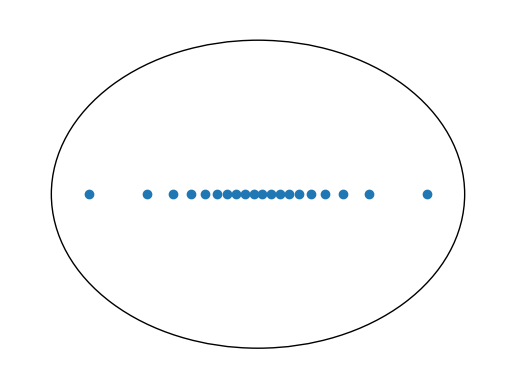

In [ ]:
# So supposing we fix w to 0, what coordinates do we get?
# This is where evenly-spaced thetas end up:

thetas = np.linspace(np.pi / 4 + 0.01, 3 / 4 * np.pi - 0.01, 20)

coefs = np.sqrt(-1 / np.cos(2 * thetas))
coordinates = np.stack(
    [
        np.cosh(w) * coefs * np.sin(thetas),  # timelike
        np.cosh(w) * coefs * np.cos(thetas),  # decision
        np.sinh(w) * np.ones_like(thetas),  # variable
    ],
    axis=1,
)

# Convert to Poincare ball
gplot(coordinates, space="H2_poincare_disk")


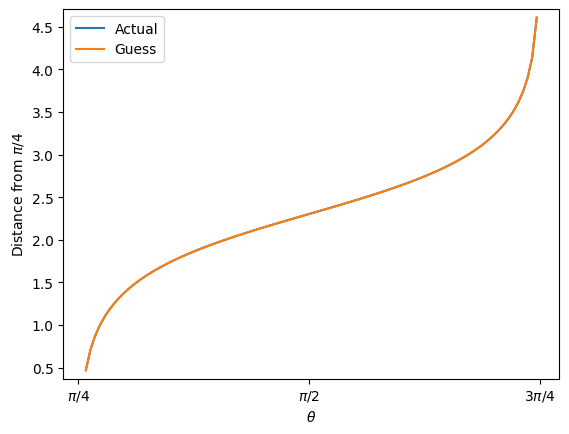

In [ ]:
# Notice that for these points, the last dimension is always 0 since we fix w = 0
# Then we actually have a simpler system:
# a(theta) = sqrt(-sec(2 theta))
# <x0, xD, xt> = <a(theta) * sin(theta), a(theta) * cos(theta), 0>

# However, determining the distances between these points is not trivial...

# Can we just approximate this function somehow?
def get_point(theta, w=0):
    coef = np.sqrt(-1 / np.cos(2 * theta))
    return np.array(
        [
            np.cosh(w) * coef * np.sin(theta),  # timelike
            np.cosh(w) * coef * np.cos(theta),  # decision
            np.sinh(w) * np.ones_like(theta),  # variable
        ]
    )


# Plot the actual distances from pi/4 to 3pi/4
thetas = np.linspace(np.pi / 4 + 0.01, 3 * np.pi / 4 - 0.01, 100)
points = np.array([get_point(theta) for theta in thetas])
dists = [manifold.metric.dist(points[0], p2) for p2 in points[1:]]
plt.plot(thetas[1:], dists, label="Actual")

# Guess
a1 = np.sqrt(-1 / np.cos(2 * thetas[0]))
a2 = np.sqrt(-1 / np.cos(2 * (thetas[1:])))
guess = np.arccosh(-a1 * a2 * np.cos(thetas[0] + thetas[1:]))
plt.plot(thetas[1:], guess, label="Guess")
plt.ylim(np.min(dists) - 0.1, np.max(dists) + 0.1)

plt.xlabel(r"$\theta$")
plt.xticks(
    [np.pi / 4, np.pi / 2, 3 * np.pi / 4], [r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$"]
)
plt.ylabel(r"Distance from $\pi/4$")
plt.legend()
plt.show()


Here we have shown that the distance between $\theta_1$ and $\theta_2$ is
$$
\delta(\theta_1, \theta_2) = \text{arccosh}\left(\sqrt{-\sec(2\theta_1)}\sqrt{-\sec(2\theta_2)}\cos(\theta_1 + \theta_2)\right)
$$

Here is how I derived this:
$$
\begin{align*}
a(\theta) &:= \sqrt{-\sec(2\theta)}\\
p(\theta, t) &= \langle a(\theta_1)\cosh(t)\sin(\theta_1), a(\theta_2)\cosh(t)\cos(\theta_2), \sinh(t) \rangle\\
\end{align*}
$$

We consider specifically the distance between $p(\theta_1, 0)$ and $p(\theta_2, 0)$:

$$
\begin{align*}
p_1 &:= p(\theta_1, 0) = \langle a(\theta_1)\sin(\theta_1), a(\theta_1)\cos(\theta_1), 0 \rangle\\
p_2 &:= p(\theta_2, 0) = \langle a(\theta_2)\sin(\theta_2), a(\theta_2)\cos(\theta_2), 0 \rangle\\
\delta(p_1, p_2) &= \text{arccosh}(p_{1,1}p_{2,1} - p_{1,0}p_{2,0})\\
&= \text{arccosh}(a(\theta_1)a(\theta_2)\left[ \cos(\theta_1)\cos(\theta_2) - \sin(\theta_1)\sin(\theta_2) \right])\\
&= \text{arccosh}(a(\theta_1)a(\theta_2)\cos(\theta_1 + \theta_2))

\end{align*}
$$

In [ ]:
np.arccosh(-a1 * a2 * np.cos(thetas[0] + thetas[1:]))


array([0.47135707, 0.70976045, 0.87070407, 0.99245651, 1.09049386,
       1.17263369, 1.24337977, 1.30556529, 1.36108896, 1.41128568,
       1.45712988, 1.49935473, 1.53852585, 1.57508882, 1.60940101,
       1.64175348, 1.67238652, 1.70150087, 1.72926601, 1.75582641,
       1.78130626, 1.80581319, 1.82944113, 1.85227259, 1.87438052,
       1.8958298 , 1.91667841, 1.93697847, 1.95677705, 1.97611685,
       1.99503682, 2.01357261, 2.031757  , 2.04962027, 2.06719054,
       2.08449396, 2.10155501, 2.1183967 , 2.13504073, 2.15150765,
       2.16781705, 2.18398763, 2.20003735, 2.21598354, 2.23184301,
       2.24763209, 2.2633668 , 2.27906286, 2.2947358 , 2.31040105,
       2.32607399, 2.34177005, 2.35750476, 2.37329384, 2.38915331,
       2.4050995 , 2.42114922, 2.4373198 , 2.4536292 , 2.47009613,
       2.48674015, 2.50358184, 2.5206429 , 2.53794631, 2.55551658,
       2.57337986, 2.59156425, 2.61010003, 2.62902   , 2.64835981,
       2.66815838, 2.68845844, 2.70930705, 2.73075633, 2.75286

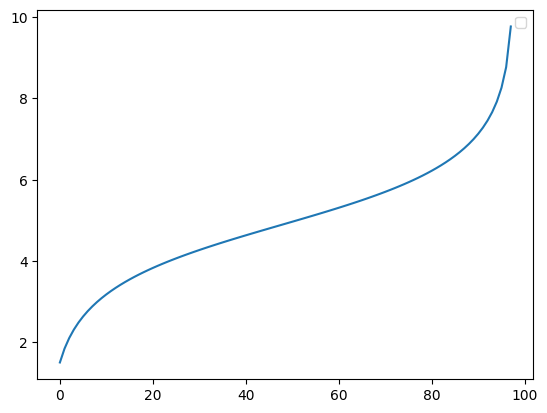

In [ ]:
# What if we plot distance as a function of angle difference?

# _x = np.array([x - thetas[0] for x in thetas[1:]])

# plt.plot(angle_diffs, dists, label="Actual")

# guess = (_x - 0.5) ** 3
# plt.plot(angle_diffs, guess, label="Guess")

# euclidean_dists = [np.linalg.norm(x - thetas[0]) for x in thetas[1:]]
# plt.plot(euclidean_dists, dists, label="Euclidean")

dist_ratios = [d / dists[0] for d in dists[1:]]
plt.plot(dist_ratios)

plt.legend()
plt.show()


In [ ]:
# OK, what if we solve numerically?
from scipy.optimize import minimize


def dist_to_points(midpoint, theta1, theta2):
    midpoint = midpoint[0]
    Xm = get_point(midpoint, w=0)
    X1 = get_point(theta1, w=0)
    X2 = get_point(theta2, w=0)
    dist1 = manifold.metric.dist(Xm, X1)
    dist2 = manifold.metric.dist(Xm, X2)
    score = np.abs(dist1 - dist2)
    if np.isnan(score):
        score = np.inf
    return score


theta1 = np.pi / 4 + 0.01
theta2 = np.pi / 2 - 0.01

best_point = minimize(
    dist_to_points,
    x0=np.array((theta1 + theta2) / 2),
    args=(theta1, theta2),
    bounds=[(theta1, theta2)],
).x


In [ ]:
def get_midpoint(theta1, theta2):
    tmin = np.min([theta1, theta2])
    tmax = np.max([theta1, theta2])
    return minimize(
        dist_to_points,
        x0=np.array((theta1 + theta2) / 2),
        args=(theta1, theta2),
        bounds=[(tmin, tmax)],  # Note parens inside brackets
    ).x[0]


vals = np.zeros((100, 100))
thetas = np.linspace(np.pi / 4 + 0.01, 3 * np.pi / 4 - 0.01, 100)
for i in range(100):
    for j in range(100):
        vals[i, j] = get_midpoint(thetas[i], thetas[j])

plt.imshow(vals)
plt.xlabel("theta1")
plt.ylabel("theta2")
plt.colorbar(label="Position of midpoint")


In [ ]:
# Contour plot of vals

plt.contourf(thetas, thetas, vals)
plt.xlabel("Theta1")
plt.xticks(
    [np.pi / 4, np.pi / 2, 3 * np.pi / 4], [r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$"]
)
plt.ylabel("Theta2")
plt.yticks(
    [np.pi / 4, np.pi / 2, 3 * np.pi / 4], [r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$"]
)
plt.colorbar(label="Midpoint")
plt.show()


TypeError: '<=' not supported between instances of 'numpy.ndarray' and 'numpy.ndarray'

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous view', 'arrow-left', 'back'), ('Forward', 'Forward to next view', 'arrow-right', 'forward'), ('Pan', 'Left button pans, Right button zooms\nx/y fixes axis, CTRL fixes aspect', 'arrows', 'pan'), ('Zoom', 'Zoom to rectangle\nx/y fixes axis', 'square-o', 'zoom'), ('Download', 'Download plot', 'floppy-o', 'save_figure')]))

In [ ]:
%matplotlib widget

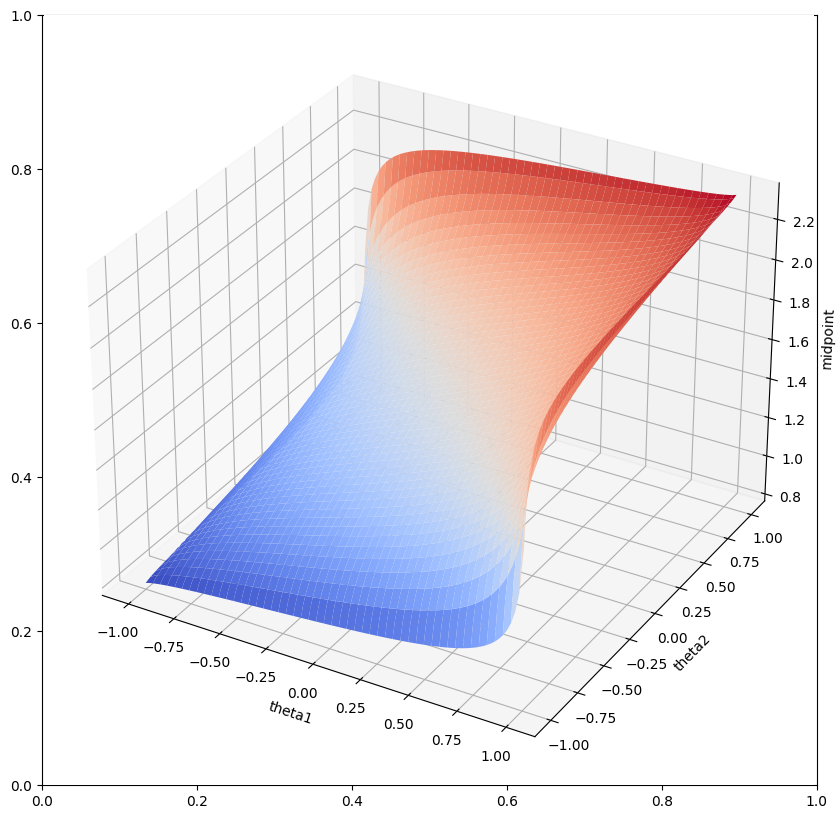

In [ ]:
# 3-d plot of vals

fig, ax = plt.subplots(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

# 3-d plot: x=theta1, y=theta2, z=vals[theta1, theta2]
ax.plot_surface(
    *np.meshgrid(
        np.linspace(-1, 1, 100),
        np.linspace(-1, 1, 100),
    ),
    vals,
    cmap="coolwarm",
)
ax.set_xlabel("theta1")
ax.set_ylabel("theta2")
ax.set_zlabel("midpoint")
plt.show()


In [ ]:
np.savetxt("dists.csv", np.stack([thetas[1:], dists], axis=1))


Now we need to consider how to evenly space the midpoint between two angles $\theta_1$ and $\theta_2$. Currently, we take the midpoint naively:
$$
\theta_\text{naive} = \frac{\theta_1 + \theta_2}{2}
$$

If we assume without loss of generality that we have $\sin(\theta_1) < \sin(\theta_2)$ (i.e. $\theta_2$) hits higher on the hyperboloid than $\theta_1$, then $\theta_\text{naive}$ will hit closer to $\theta_1$:
$$
\delta(\theta_1, \theta_\text{naive}) < \delta(\theta_2, \theta_\text{naive})
$$

How can we specify some function $F(\theta_1, \theta_2) = \theta_m \in [\theta_1, \theta_2]$ such that $\theta_m$ such that
$$
\delta(\theta_1, \theta_m) = \delta(\theta_2, \theta_m)
$$

In order to do this, we need a way of computing hyperbolic distances, so we make use of the pseudo-Euclidean metric in our ambient Minkowski space. In particular, we have the distance between two points defined as:
$$
\begin{align*}
Q(x_0, x_D) &= x_D^2 - x_0^2\\
B(u, v) &= \frac{Q(u+v) - Q(u) - Q(v)}{2}\\
&= x_Dy_D - x_0y_0\\
d(u, v) &= \text{arcosh}(-B(u,v))\\
&= \text{arcosh}(x_0y_0 - x_Dy_D)\\
&= \ln\left(x_0y_0 - x_Dy_D + \sqrt{(x_0y_0 - x_Dy_D)^2 - 1}\right)
\end{align*}
$$

In [ ]:
# THis code deals with the question of whether higher-dimensional hyperboloids
# still have all geodesics contained to one side or another of the decision
# boundary. I have struggled to prove this in terms of actual geodesics, but
# here we can approach this via numerical simulations instead.

from src.hyperdt.toy_data import generate_gaussian_mixture_hyperboloid


def B(u, v):
    """Minkowski bilinear form"""
    if u.ndim == 1 and v.ndim == 1:
        return np.sum(u[1:] * v[1:]) - u[0] * v[0]
    else:
        return np.sum(u[:, 1:] * v[:, 1:], axis=1) - u[:, 0] * v[:, 0]


points, labels = generate_gaussian_mixture_hyperboloid(
    num_points=1000,
    num_classes=2,
    noise_std=0.1,
    n_dim=10,
    default_coords_type="extrinsic",
    seed=0,
)


In [ ]:
# u_vecs = points.copy()
# u_vecs[:, 0] = 0.0
# u_vecs = u_vecs / np.linalg.norm(u_vecs, axis=1)[:, None]
# assert np.allclose(B(u_vecs, u_vecs), 1.)

# v_vecs = np.array([[1.0, 0.0, 0.0, 0.0] for _ in range(1000)])
# assert np.allclose(B(v_vecs, v_vecs), -1.)


def scale_minkowski(vector, desired_norm):
    """Scales a vecotr so that it has a certain norm"""
    factor = np.sqrt(desired_norm / B(vector, vector))
    return factor * vector, factor


# diff_vector = points[0] - points[1]
# diff_timelike = np.zeros(3)
# diff_spacelike = np.zeros(3)
# diff_timelike[0] = diff_vector[0]
# diff_spacelike[1:] = diff_vector[1:]
# u_vector, u_factor = scale_minkowski(points[1] - points[0], 1)
# v_vector, v_factor = scale_minkowski(points[0], -1)
direction_vector = points[1] - points[0]
orthgonal_vector = direction_vector.copy()

u_vector = space_vector
v_vector, v_factor = scale_minkowski(projected_direction_vector, -1)

# Verify our vectors are well-behaved:
print(B(u_vector, u_vector))
print(B(v_vector, v_vector))
print(B(u_vector, v_vector))

# Verify that we can still express points[0], points[1] in terms of u, v
# assert np.allclose(points[0], u_factor * u_vector)


NameError: name 'space_vector' is not defined

In [ ]:
# We can't use gram-schmidt because it doesn't preserve B(u, v) = 0


def gram_schmidt(vectors):
    basis = []
    for v in vectors:
        w = v - sum(np.dot(v, b) * b for b in basis)
        if (w > 1e-10).any():
            basis.append(w / np.linalg.norm(w))
    return np.array(basis)


basis = gram_schmidt([points[0], points[1] - points[0]])
u, u_factor = scale_minkowski(basis[1], 1)
v, v_factor = scale_minkowski(basis[0], -1)

print(B(v, v))
print(B(u, u))
print(B(u, v))


-1.0
1.0000000000000002
-98.82204524509868


In [ ]:
# Maybe we can just address this by simulation:
# Here we see that we never see (in our sample) a geodesic between two points in
# the same subtree that crosses the decision boundary!

from src.hyperdt.tree import HyperbolicDecisionTreeClassifier
from geomstats.geometry.hyperbolic import Hyperbolic

hdt = HyperbolicDecisionTreeClassifier()
hdt.fit(points, labels)

manifold = Hyperbolic(dim=points.shape[1] - 1, default_coords_type="extrinsic")

# Verify that all geodesics have all points in left subtree
# theta = hdt.tree.theta
for trial_num in range(100):
    print(trial_num)
    theta = np.random.rand() * np.pi / 2 + np.pi / 4  # Random angle
    dim = np.random.randint(3) + 1  # Random dimension
    for point1 in points:
        dp1 = hdt._dot(point1, theta=theta, dim=dim)
        for point2 in points:
            if np.allclose(point1, point2):
                continue
            dp2 = hdt._dot(point2, theta=theta, dim=dim)
            if np.sign(dp1) != np.sign(dp2):
                continue

            geodesic_func = manifold.metric.geodesic(
                initial_point=point1,
                end_point=point2,
            )
            geodesic_points = geodesic_func(np.linspace(0, 1, 100))
            geodesic_points = geodesic_points[manifold.belongs(geodesic_points)]

            for point in geodesic_points:
                # Verify it has the same sign
                dpg = hdt._dot(point, theta=theta, dim=dim)
                if np.sign(dp1) != np.sign(dpg):
                    print("Violation!")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


KeyboardInterrupt: 

Using the derivation for the distance function above, I found a simplified
condition for $\theta_m$ to be a midpoint of $\theta_1$ and $\theta_2$:

$$
\begin{align*}
    \alpha(\theta) &:= \sqrt{-\sec(2\theta)}\\
    \delta(a, b) &:= \cosh^{-1}\left( \alpha(a)\alpha(b)\cos(a + b) \right)\\
    \cosh^{-1}(\alpha(\theta_1)\alpha(\theta_m)\cos(\theta_1 + \theta_m)) &= \cosh^{-1}(\alpha(\theta_m)\alpha(\theta_2)\cos(\theta_m + \theta_2))\\
\end{align*}
$$

Observing that $\cosh^{-1}$ is a monotonic function, we can simplify this to:
$$
\begin{align*}
    \alpha(\theta_1)\alpha(\theta_m)\cos(\theta_1 + \theta_m) &= \alpha(\theta_m)\alpha(\theta_m)\cos(\theta_m + \theta_2)\\
    \alpha(\theta_1)\cos(\theta_1 + \theta_m) &= \alpha(\theta_m)\cos(\theta_m + \theta_2)\\
    \sqrt{-\sec(2\theta_1)}\cos(\theta_1 + \theta_m) &= \sqrt{-\sec(2\theta_m)}\cos(\theta_m + \theta_2)\\
    \sec(2\theta_1)\cos^2(\theta_1 + \theta_m) &= \sec(2\theta_2)\cos^2(\theta_m + \theta_2)\\
    \frac{\cos^2(\theta_1 + \theta_m)}{\cos(\theta_2)} &= \frac{\cos^2(\theta_m + \theta_2)}{\cos(\theta_1)}\\
    \frac{\cos^2(\theta_1 + \theta_m)}{\cos(\theta_2)} - \frac{\cos^2(\theta_m + \theta_2)}{\cos(\theta_1)} &= 0\\
    \cos(\theta_2)\cos^2(\theta_1 + \theta_m) - \cos(\theta_1)\cos^2(\theta_2 + \theta_m) &= 0\\
\end{align*}
$$
This last expression can be solved numerically.

In [ ]:
from scipy.optimize import root_scalar


def _dist(x1, x2):
    """Closed form for distance between two points on intersection of
    hyperboloid and plane such that all other coordinates are 0"""
    a1 = np.sqrt(-1 / np.cos(2 * x1))  # sqrt(-sec(2x_1))
    a2 = np.sqrt(-1 / np.cos(2 * x2))  # sqrt(-sec(2x_2))
    dist = np.arccosh(-a1 * a2 * np.cos(x1 + x2))

    # Deal with really close values - numerical weirdness
    if np.abs(dist) < 1e-6 or np.abs(x1 - x2) < 1e-6:
        dist = 0
    return dist


def _dist_aberration(m, x1, x2):
    """This is 0 when d(theta1, m) = d(theta2, m) = d(theta1, theta2)/2"""
    # return np.cos(x1) * np.cos(x2 + m) ** -np.cos(x2) * np.cos(x1 + m) ** 2
    return _dist(x1, m) - _dist(m, x2)


def midpoint(x1, x2):
    """Find hyperbolic midpoint of two angles"""
    xmin = np.min([x1, x2])
    xmax = np.max([x1, x2])
    return root_scalar(
        _dist_aberration, args=(x1, x2), bracket=[xmin, xmax]
    ).root


for i in range(100):
    print(i)
    # Sample two random angles from pi/4 to 3pi/4
    x_1 = np.random.uniform(np.pi / 4, 3 * np.pi / 4)
    x_2 = np.random.uniform(np.pi / 4, 3 * np.pi / 4)

    # Find the root of the function
    x_m = midpoint(x_1, x_2)

    # Compute the distance between the points
    d_1 = _dist(x_1, x_m)
    d1_r = _dist(x_m, x_1)
    d_2 = _dist(x_2, x_m)
    d2_r = _dist(x_m, x_2)
    d_3 = _dist(x_1, x_2)

    assert np.isclose(d_1, d_2)
    assert np.isclose(d_1 * 2, d_3)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


/tmp/ipykernel_4019551/2329515499.py:9: RuntimeWarning: invalid value encountered in arccosh
  dist = np.arccosh(-a1 * a2 * np.cos(x1 + x2))


In [ ]:
np.arccosh(-np.sqrt(-1 / cos(1.5)))


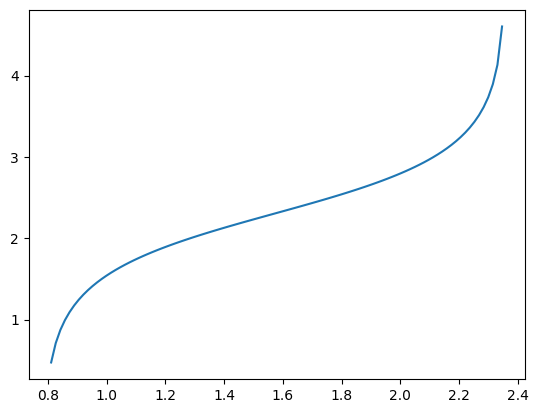

In [ ]:
import matplotlib.pyplot as plt

_x = np.linspace(np.pi / 4 + 0.01, 3 * np.pi / 4 - 0.01, 100)
plt.plot(
    _x[1:], [_dist(_x[0], x) for x in _x[1:]], label="Distance from origin"
)
plt.show()


In [ ]:
# Great, so now I implemented that function. Let's see if it works

from src.hyperdt.hyperbolic_trig import get_candidates_hyperbolic

hdt = HyperbolicDecisionTreeClassifier(
    timelike_dim=0, dot_product="sparse", max_depth=1
)
hdt.fit(points, labels)

print(points.shape)  # (1000, 11)
# midpoints = get_candidates_hyperbolic(points, dim=2, timelike_dim=0)
midpoints = hdt._get_candidates(points, dim=2)
print(midpoints.shape)

# Sanity check: our classes move one at a time
for theta in midpoints:
    l, r = hdt._get_split(points, dim=2, theta=theta)
    print(l.sum(), r.sum())  # 0 1000

# for theta in hdt._get_candidates(points, dim=2):
#     l, r = hdt._get_split(points, dim=2, theta=theta)
#     print(l.sum(), r.sum()) # 0 1000


(1000, 11)
(999,)
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
0 1000
1 999
1 999
1 999
1 999
1 999
2 998
2 998
2 998
2 998
2 998
2 998
2 998
2 998
2 998
2 998
2 998
2 998
2 998
2 998
2 998
2 998
2 998
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4 996
4